# Giới thiệu
Này mọi người, chào mừng đến với hạt nhân này. Trong phần nhân này, tôi sẽ chỉ cho bạn cách xây dựng một mạng nơ-ron phức hợp bằng cách sử dụng Pytorch.

Tôi đã từng làm việc với Tensorflow, nhưng gần đây tôi quyết định thay đổi thư viện học sâu chính của mình thành Pytorch. Tôi đã nghiên cứu chi tiết cả Tensorflow và Pytorch (thực sự) và Pytorch có vẻ tốt hơn đối với tôi.

Vì vậy, chúng ta hãy bắt đầu!

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

# Chuẩn bị Tập dữ liệu
Pytorch cung cấp các công cụ nâng cao để đọc, chia nhóm và chuẩn bị dữ liệu hình ảnh và hôm nay chúng ta sẽ sử dụng các công cụ đó.

Nói chung, chuẩn bị dữ liệu trong pytorch có 3 bước.

** 1. Chuẩn bị lớp tập dữ liệu **

** 2. Đang chuẩn bị lấy mẫu **

** 3. Chuẩn bị Trình tải dữ liệu **


### 1. Chuẩn bị Lớp tập dữ liệu
Đầu tiên, chúng ta sẽ tạo một lớp tập dữ liệu bằng cách kế thừa lớp tập dữ liệu trừu tượng của lớp Pytorch. Có một số chức năng đặc biệt chúng ta phải ghi đè. Chúng ta sẽ thấy chúng trong mã.

In [2]:
# * Chúng tôi sẽ sử dụng lớp này để kiểm soát mọi thứ.
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
class AnimalDataset(Dataset):
    
    def __init__(self,img_paths,img_labels,size_of_images):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.size_of_images = size_of_images
        if len(self.img_paths) != len(self.img_labels):
            raise InvalidDatasetException(self.img_paths,self.img_labels)
        
    
    # We need to override __len__ special method
    def __len__(self):
        return len(self.img_paths)
    
    # Also we need to override __getitem__ special method
    # This method should return the image and its label from index given.
    def __getitem__(self,index):
        PIL_IMAGE = Image.open(self.img_paths[index]).resize(self.size_of_images)
        # In pytorch we use torch tensors, ToTensor transform transforms the PIL image 
        # to Torch tensor.
        TENSOR_IMAGE = transform(PIL_IMAGE)
        label = self.img_labels[index]
        
        return TENSOR_IMAGE,label

* Nếu chúng ta muốn giải thích ngắn gọn chức năng của lớp này, nó sẽ đọc hình ảnh và chuyển đổi nó thành Torch tensor. Sau đó, nó trả về hình ảnh và nhãn của hình ảnh.

* Hãy tạo đối tượng của chúng ta.

In [5]:
paths = []
labels = []
label_map = {0:"Cat",
             1:"Dog",
             2:"Wild"
            }

for cat_path in glob("../input/animal-faces/afhq/train/cat/*") + glob("../input/animal-faces/afhq/val/cat/*"):
    paths.append(cat_path)
    labels.append(0)
    
for dog_path in glob("../input/animal-faces/afhq/train/dog/*") + glob("../input/animal-faces/afhq/val/dog/*"):
    paths.append(dog_path)
    labels.append(1)
    
for wild_path in glob("../input/animal-faces/afhq/train/wild/*") + glob("../input/animal-faces/afhq/val/wild/*"):
    paths.append(wild_path)
    labels.append(2)
    
print(len(paths))
print(len(labels))

16130
16130


In [6]:
dataset = AnimalDataset(paths,labels,(250,250))

* Chúng tôi đã hoàn thành phần khó nhất của việc chuẩn bị dữ liệu. Bây giờ chúng ta sẽ tạo đối tượng sampler.
* Về cơ bản, trình lấy mẫu cho thấy cách chúng tôi chọn dữ liệu.
* Chúng tôi sẽ tạo hai bộ lấy mẫu ngẫu nhiên: Đào tạo bộ lấy mẫu ngẫu nhiên và bộ lấy mẫu ngẫu nhiên thử nghiệm.
* Những người lấy mẫu ngẫu nhiên này sẽ chọn ngẫu nhiên các chỉ số từ danh sách đã cho. Bạn chắc chắn sẽ hiểu khi bạn nhìn thấy. Hãy mã hóa nó.

### 2. Chuẩn bị Đối tượng lấy mẫu

In [7]:
from sklearn.model_selection import train_test_split

# dataset_indices = [0,1,2,3,..len(dataset)-1]
dataset_indices = list(range(0,len(dataset)))

train_indices,test_indices = train_test_split(dataset_indices,test_size=0.2,random_state=42)
print("Number of train samples: ",len(train_indices))
print("Number of test samples: ",len(test_indices))

Number of train samples:  12904
Number of test samples:  3226


* Và bây giờ tất cả những gì chúng ta cần làm là đưa các danh sách chỉ số này cho người lấy mẫu của chúng ta.

In [8]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

### 3. Chuẩn bị Đối tượng Trình tải Dữ liệu
Mọi thứ đã sẵn sàng để kết hợp. Chúng tôi có một tập dữ liệu, chúng tôi có thể đọc hình ảnh và nhãn. Chúng tôi có người lấy mẫu sẽ giúp chúng tôi chọn mẫu ngẫu nhiên. Và bây giờ chúng ta cần một bộ tải dữ liệu sẽ tạo các lô bằng cách sử dụng bộ dữ liệu và bộ lấy mẫu.

In [9]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=test_sampler)

* Mọi thứ đã sẵn sàng về dữ liệu. Hãy chuyển sang mô hình mạng nơ-ron.


Nhưng trước đây, chúng ta hãy xem những hình ảnh của chúng tôi.

In [10]:
dataset[1][0].shape

torch.Size([3, 250, 250])

In [11]:
images,labels = next(iter(train_loader))
type(labels)

torch.Tensor

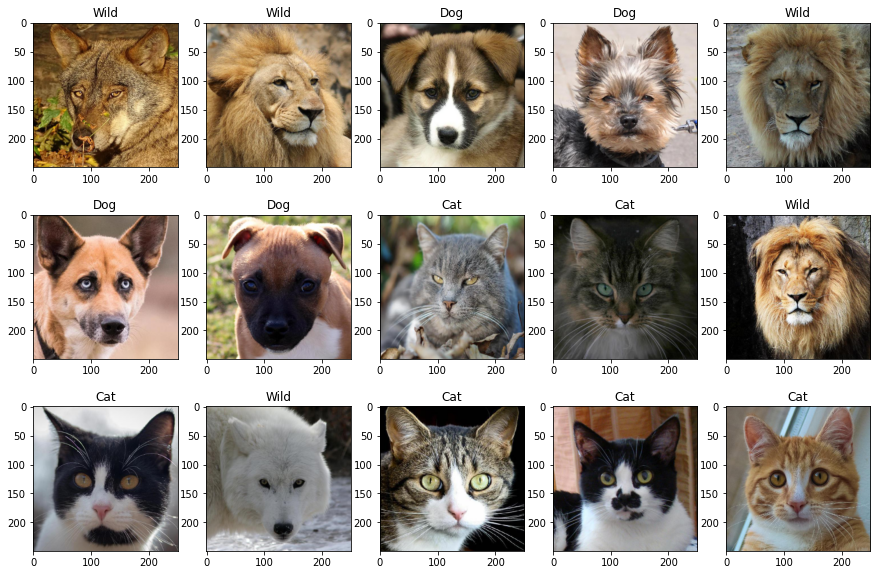

In [12]:
images,labels = iter(train_loader).next()

fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[int(labels[i])]
        ax.imshow(npimg)
        ax.set(title = f"{label}")
        

# Tạo mô hình mạng thần kinh
Tập dữ liệu của chúng tôi đã sẵn sàng, bây giờ chúng tôi có thể xây dựng mạng nơ-ron tích hợp sâu của mình. Trong Pytorch, khi chúng ta xây dựng một mô hình, chúng ta tạo một lớp kế thừa lớp trừu tượng nn.Module của Pytorch.

Sau đó, chúng ta cần viết hàm chuyển tiếp bao gồm truyền chuyển tiếp.

In [13]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        # First we'll define our layers
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256 * 2 * 2,512)
        self.fc2 = nn.Linear(512,3)
        
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.maxpool(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x
        
        

* Bây giờ chúng ta có thể tạo đối tượng mô hình của mình.
* Nhưng trước khi cần tạo biến GPU, chúng tôi sẽ gửi mô hình của mình tới gpu theo cách đó.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cpu')

In [16]:
model = CNN().to(device)

Cũng như bạn đã biết, trong học tập sâu, chúng tôi sử dụng một thuật toán tối ưu hóa để áp dụng gradient và một hàm mất mát để tính toán gradient. Trong nhân này, chúng ta sẽ sử dụng mất entropy chéo và trình tối ưu hóa RMSProp.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

# Mô hình đào tạo
Mô hình và tập dữ liệu của chúng tôi đã sẵn sàng, bây giờ chúng tôi có thể đào tạo mô hình của mình.

In [18]:
EPOCH_NUMBER = 5
TRAIN_LOSS = []
TRAIN_ACCURACY = []

for epoch in range(1,EPOCH_NUMBER+1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for data_,target_ in train_loader:
        # We have to one hot encode our labels.
        target_ =target_.to(device)
        data_ = data_.to(device)
        
        # Cleaning the cached gradients if there are
        optimizer.zero_grad()
        
        # Getting train decisions and computing loss.
        outputs = model(data_)
        loss = criterion(outputs,target_)
        
        # Backpropagation and optimizing.
        loss.backward()
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        correct = correct + torch.sum(pred == target_).item()
        total += target_.size(0)
    
    # Appending stats to the lists.
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    print(f"Epoch {epoch}: Accuracy: {100 * correct/total}, Loss: {epoch_loss}")
        

Epoch 1: Accuracy: 83.15251084934904, Loss: 49.43000918626785
Epoch 2: Accuracy: 95.12554246745195, Loss: 14.54082316160202
Epoch 3: Accuracy: 97.61314321140732, Loss: 7.517675016075373
Epoch 4: Accuracy: 99.25604463732176, Loss: 3.430280833505094
Epoch 5: Accuracy: 99.62027278363298, Loss: 1.8116460901219398


** Chúng tôi đã đào tạo mô hình của mình và bây giờ chúng tôi có thể xem xét các số liệu thống kê và sau đó chúng tôi có thể đánh giá mô hình của mình bằng cách sử dụng bộ thử nghiệm. **

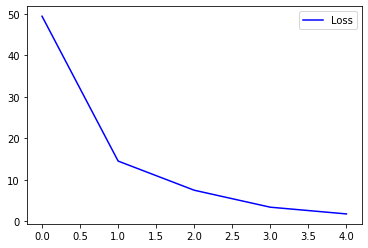

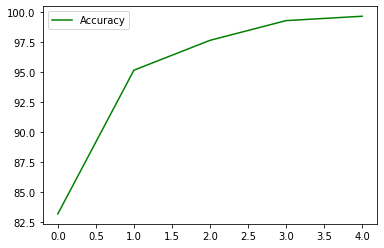

In [19]:
plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_LOSS,color="blue",label="Loss")
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_ACCURACY,color="green",label="Accuracy")
plt.legend()
plt.show()

# Bài kiểm tra cuối cùng
Và bây giờ chúng tôi sẽ kiểm tra mô hình của chúng tôi bằng cách sử dụng trình tải thử nghiệm của chúng tôi.

In [20]:
total_val_loss = 0.0
total_true = 0
total = len(test_sampler)

# When we're not working with gradients and backpropagation
# we use torch.no_grad() utility.
with torch.no_grad():
    model.eval()
    for data_,target_ in validation_loader:
        data_ = data_.to(device)
        target_ = target_.to(device)
        
        outputs = model(data_)
        loss = criterion(outputs,target_).item()
        _,preds = torch.max(outputs,dim=1)
        total_val_loss += loss
        true = torch.sum(preds == target_).item()
        total_true += true

validation_accuracy = round(100 * total_true / total,2)
print(f"Validation accuracy: {validation_accuracy}%")
print(f"Validation loss: {round(total_val_loss,2)}%")

Validation accuracy: 94.02%
Validation loss: 5.1%


* Và bùng nổ, mô hình của chúng tôi đã sẵn sàng để sử dụng!

# Cách Lưu Mô hình Pytorch
Chúng tôi đã đào tạo mô hình của mình và chúng tôi có thể muốn sử dụng nó trong cuộc sống thực của mình. Và để sử dụng thường xuyên chúng ta cần lưu lại.

Có rất nhiều cách để lưu một mô hình trong Pytorch nhưng hôm nay chúng ta sẽ sử dụng cách tốt nhất: lưu state dict.


Từ điển trạng thái là một từ điển python bao gồm tên lớp dưới dạng khóa và trọng số lớp dưới dạng mục. Nếu chúng ta nhìn vào điều khoản nhà nước, chúng ta có thể hiểu đầy đủ về nó.

In [21]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
batchnorm1.weight 	 torch.Size([64])
batchnorm1.bias 	 torch.Size([64])
batchnorm1.running_mean 	 torch.Size([64])
batchnorm1.running_var 	 torch.Size([64])
batchnorm1.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
batchnorm2.weight 	 torch.Size([128])
batchnorm2.bias 	 torch.Size([128])
batchnorm2.running_mean 	 torch.Size([128])
batchnorm2.running_var 	 torch.Size([128])
batchnorm2.num_batches_tracked 	 torch.Size([])
conv4.weight 	 torch.Size([256, 128, 3, 3])
conv4.bias 	 torch.Size([256])
batchnorm3.weight 	 torch.Size([256])
batchnorm3.bias 	 torch.Size([256])
batchnorm3.running_mean 	 torch.Size([256])
batchnorm3.running_var 	 torch.Size([256])
batchnorm3.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([512, 1024])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.

* Và như bạn đoán, chúng ta chỉ có thể lưu và tải lệnh trạng thái này.

In [22]:
torch.save(model.state_dict(),"model.pt")


* Và để tải mô hình, chúng ta cần tạo một đối tượng mới từ lớp và tải trạng thái dict.

In [23]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

# Sự kết luận
Cảm ơn đã quan tâm. Nếu bạn có một câu hỏi, xin vui lòng chia sẻ nó với tôi. Tôi rất hân hạnh được giúp đỡ bạn. Chúc bạn ngày mới tốt lành!